## CS109A: Final Project - EA Sports - FIFA

Import libraries and data

In [81]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler
!pip install mplsoccer
from mplsoccer.pitch import Pitch

  Using cached mplsoccer-0.0.21.tar.gz (33 kB)
  Created wheel for mplsoccer: filename=mplsoccer-0.0.21-py3-none-any.whl size=32698 sha256=32fedfb45164d8b63f229ef5c7dc64d3c9e85bec1bcdd253d9b5eadca9f8be34
  Stored in directory: /Users/haeyun/Library/Caches/pip/wheels/ef/0f/b6/82e8bd7b398191da49ca2aeced6e6297357543d8601dca58ca
Successfully built mplsoccer


<a id="Contents"></a>

## Contents
- [Part A: Rank the Players](#Q1) 
- [Part B: Classify Player Position](#Q2) 
- [Part C: Club with the Best Staff](#Q3)
- [Part D: Predicting Skill Stats for 2021](#Q4)

<a id="Q1"></a>

## <div class='exercise'> <b> Part A - Rank the Players  </b></div>

Using the FIFA 19 dataset, we will:
*  Predict the Overall (OVR) skill Statistic for players in the FIFA 20 Edition.
*  Train on all players from FIFA 19
*  Graphically represent the Overall data for the players in Test Set

In [2]:
q1_players_19 = pd.read_csv('players_19.csv')
q1_players_20 = pd.read_csv('players_20.csv')
players_20_position_ovr = q1_players_20[['sofifa_id', 'player_positions', 'overall']].copy()
players_20_position_ovr.columns = ['sofifa_id', 'player_positions_20', 'overall_20']
q1_players_19 = q1_players_19.merge(players_20_position_ovr, how='outer', on='sofifa_id')
q1_players_19.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,player_positions_20,overall_20
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33.0,1985-02-05,187.0,83.0,Portugal,Juventus,...,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,"ST, LW",93.0
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31.0,1987-06-24,170.0,72.0,Argentina,FC Barcelona,...,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2,"RW, CF, ST",94.0
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26.0,1992-02-05,175.0,68.0,Brazil,Paris Saint-Germain,...,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,"LW, CAM",92.0
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27.0,1990-11-07,193.0,76.0,Spain,Manchester United,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK,89.0
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27.0,1991-06-28,181.0,70.0,Belgium,Manchester City,...,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,"CAM, CM",91.0


Clean up and simplify varius elements of the data.

In [3]:
q1_players_19 = q1_players_19[q1_players_19.body_type.isin(('Lean', 'Normal', 'Stocky'))]
q1_body_type_one_hot = pd.get_dummies(q1_players_19.body_type, prefix='body_type')
q1_players_19 = q1_players_19.merge(q1_body_type_one_hot, left_index=True, right_index=True).drop(columns='body_type')

player_positions_one_hot = q1_players_19.player_positions_20.str.get_dummies(sep=', ').add_prefix('plays_')
q1_players_19 = q1_players_19.merge(player_positions_one_hot, left_index=True, right_index=True).drop(columns=['player_positions', 'player_positions_20'])

team_positions_one_hot = pd.get_dummies(q1_players_19.team_position, prefix='team')
q1_players_19 = q1_players_19.merge(team_positions_one_hot, left_index=True, right_index=True).drop(columns='team_position')

q1_players_19['preferred_foot'] = (q1_players_19['preferred_foot'] == 'Right')*1

numeric_skills = ('attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb')

for i in numeric_skills:
    q1_players_19[i] = q1_players_19[i].apply(lambda x: int(re.search(r'\d+', x).group()) if type(x) == str else np.NaN)
    
goalie_nongoalie_skills = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
# A non-goalie could technically go in goal, but would be awful at it.
q1_players_19[goalie_nongoalie_skills] = q1_players_19[goalie_nongoalie_skills].fillna(0) 

q1_players_19[['work_rate_1', 'work_rate_2']] = q1_players_19.work_rate.str.split('/', n=1, expand=True)
q1_wr1_one_hot = pd.get_dummies(q1_players_19.work_rate_1, prefix='wr1')
q1_wr2_one_hot = pd.get_dummies(q1_players_19.work_rate_2, prefix='wr2')
q1_players_19 = q1_players_19.merge(q1_wr1_one_hot, left_index=True, right_index=True).merge(q1_wr2_one_hot, left_index=True, right_index=True).drop(columns=['work_rate', 'work_rate_1', 'work_rate_2'])

q1_data = q1_players_19.drop(columns=['sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'nationality', 'real_face', 'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'player_traits'])


In [4]:
q1_test_clubs = ('FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool FC')
q1_data_train = q1_data[~q1_data.club.isin(q1_test_clubs)].drop(columns='club').dropna()
q1_data_test = q1_data[q1_data.club.isin(q1_test_clubs)].drop(columns='club').dropna()
q1_X_train = q1_data_train.drop(columns='overall_20')
q1_y_train = q1_data_train['overall_20']
q1_X_test = q1_data_train.drop(columns='overall_20')
q1_y_test = q1_data_train['overall_20']
q1_data.head()

,age,height_cm,weight_kg,club,overall,potential,value_eur,wage_eur,preferred_foot,international_reputation,...,team_RW,team_RWB,team_ST,team_SUB,wr1_High,wr1_Low,wr1_Medium,wr2_High,wr2_Low,wr2_Medium
3,27.0,193.0,76.0,Manchester United,91.0,93.0,72000000.0,260000.0,1,4.0,...,0,0,0,0,0,0,1,0,0,1
4,27.0,181.0,70.0,Manchester City,91.0,92.0,102000000.0,355000.0,1,4.0,...,0,0,0,0,1,0,0,1,0,0
5,32.0,184.0,82.0,Real Madrid,91.0,91.0,51000000.0,380000.0,1,4.0,...,0,0,0,0,1,0,0,0,0,1
6,31.0,182.0,86.0,FC Barcelona,91.0,91.0,80000000.0,455000.0,1,5.0,...,0,0,1,0,1,0,0,0,0,1
7,32.0,172.0,66.0,Real Madrid,91.0,91.0,67000000.0,420000.0,1,4.0,...,0,0,0,0,1,0,0,1,0,0


Based on graphs from our EDA, which showed linear relationships between two extremely important predictors and the result, we decided to go with a linear model.  Specifically, we used Lasso, and we used SKLearn's inbuilt cross-validation to choose a Lasso parameter.  We left the defaults as they were because, on looking at them, they gave about the list of alphas we would have chosen, and this way we did not have to worry about a mistype in our code giving bad results.

In [5]:
q1_scaler = StandardScaler().fit(q1_X_train)

lasso = LassoCV()
lasso.fit(q1_scaler.transform(q1_X_train), q1_y_train)
print(f'The MSE for the Lasso linear model is {mean_squared_error(lasso.predict(q1_scaler.transform(q1_X_test)), q1_y_test):.4g}.')

The MSE for the Lasso linear model is 4.665.


A Lasso model also gives a pretty good idea of which coefficients are most important.

In [6]:
useful_coefs = [(col, coef) for (col, coef) in zip(q1_X_train.columns, lasso.coef_) if coef != 0]
useful_coefs.sort(key=lambda x: -abs(x[1]))

In [7]:
useful_coefs

[('overall', 5.361019177777301),
 ('potential', 0.48302320374973545),
 ('age', -0.28002230498610103),
 ('team_RES', -0.26568320675421647),
 ('team_SUB', -0.2397835098414753),
 ('release_clause_eur', 0.1511759152876781),
 ('skill_dribbling', 0.10528240840854923),
 ('team_GK', 0.08413293616526317),
 ('skill_curve', -0.0768168309398467),
 ('mentality_aggression', -0.0606827764941042),
 ('movement_reactions', 0.0578746872894428),
 ('plays_CM', 0.04027844158144902),
 ('defending_sliding_tackle', 0.036945254680858304),
 ('wr2_Medium', 0.032963077560656126),
 ('attacking_heading_accuracy', 0.03249097223175051),
 ('team_CM', 0.032433127162861036),
 ('wage_eur', 0.031338788463113866),
 ('team_RW', 0.0297644455960019),
 ('power_stamina', -0.028892477103724112),
 ('plays_CB', 0.02807789711643954),
 ('plays_ST', 0.027255146595747713),
 ('plays_CDM', 0.024613889883434374),
 ('movement_agility', -0.024353677202588447),
 ('plays_CF', 0.02364246092621634),
 ('international_reputation', 0.0234940454619

To validate our assumptions about the linearity of the system, let's look at MSE versus number of coefficients.  We would expect this to have an L-shape, as the model chose the most important coefficients first and capitalized on them as much as possible.

In [8]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(q1_X_train, q1_y_train, test_size=0.2, random_state = 42)

In [9]:
coefs_list = list(map(lambda x: x[0], useful_coefs))

In [10]:
coef_scores = []
for i in range(1, len(coefs_list)+1):
    s = StandardScaler()
    X_truncated_train = s.fit_transform(X_train_train[coefs_list[0:i]])
    X_truncated_val = s.transform(X_train_val[coefs_list[0:i]])
    l = LassoCV().fit(X_truncated_train, y_train_train)
    coef_scores.append(mean_squared_error(l.predict(X_truncated_val), y_train_val))

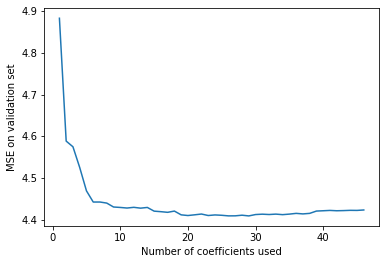

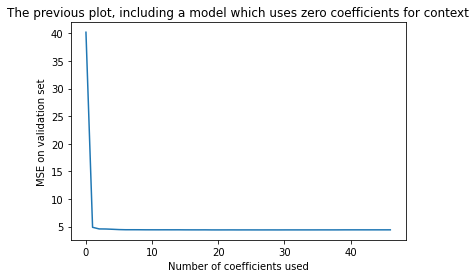

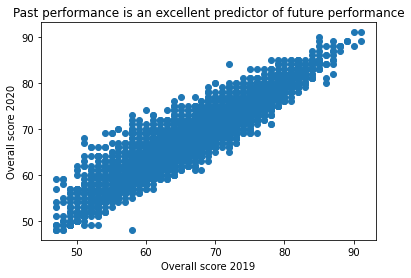

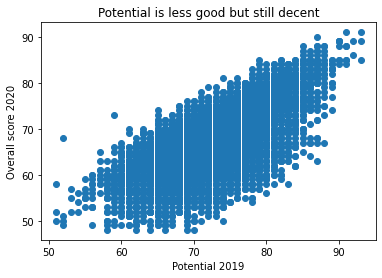

In [11]:
average = np.mean(y_train_train)
mse_average = mean_squared_error(y_train_val, np.ones(np.shape(y_train_val)) * average)

plt.plot(list(range(1, len(coefs_list)+1)), coef_scores)
plt.xlabel('Number of coefficients used')
plt.ylabel('MSE on validation set')
plt.show()

plt.plot(list(range(len(coefs_list)+1)), [mse_average] + coef_scores)
plt.xlabel('Number of coefficients used')
plt.ylabel('MSE on validation set')
plt.title('The previous plot, including a model which uses zero coefficients for context')
plt.show()

plt.scatter(q1_X_train['overall'], q1_y_train)
plt.xlabel('Overall score 2019')
plt.ylabel('Overall score 2020')
plt.title('Past performance is an excellent predictor of future performance')
plt.show()

plt.scatter(q1_X_train['potential'], q1_y_train)
plt.xlabel('Potential 2019')
plt.ylabel('Overall score 2020')
plt.title('Potential is less good but still decent')
plt.show()

Finally, let's check this against the performance of a standard baseline model: KNN with between 1 and 10 neighbors.  It can't outperform Lasso.

In [12]:
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(q1_scaler.transform(X_train_train), y_train_train)
    print(f'At i={i}, MSE is {mean_squared_error(knn.predict(q1_scaler.transform(X_train_val)), y_train_val):.4g}')

At i=1, MSE is 16.03
At i=2, MSE is 16.57
At i=3, MSE is 18.91
At i=4, MSE is 19.93
At i=5, MSE is 19.89
At i=6, MSE is 18.37
At i=7, MSE is 16.89
At i=8, MSE is 15.5
At i=9, MSE is 15.16


At this point, for visualization, we have to ask what we hope to gain by representing the overall score for players in the test set.  The most important thing to know about overall score is that it doesn't change much, year on year, so the best graphical representation of the overall score is simply this:

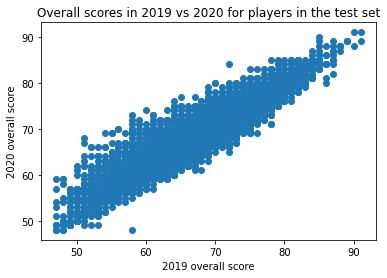

In [13]:
plt.scatter(q1_X_test['overall'], q1_y_test)
plt.xlabel('2019 overall score')
plt.ylabel('2020 overall score')
plt.title('Overall scores in 2019 vs 2020 for players in the test set')
plt.show()

<a id="Q2"></a>

## <div class='exercise'> <b> Part B - Classify Player Position  </b></div>

In this section, we will:

* Train on data from FIFA 19
* Predict the player_position variable using other skill statistics for players in the FIFA 20 Edition
* Train on all players from FIFA 19
* Graphically represent the predicted player_position for the players in Test Set 

In [14]:
q2_players_19 = pd.read_csv('players_19.csv')
q2_players_19.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,...,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,...,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


Clean up and simplify varius elements of the data.

In [15]:
q2_players_19 = q2_players_19[q2_players_19.body_type.isin(('Lean', 'Normal', 'Stocky'))]
q2_body_type_one_hot = pd.get_dummies(q2_players_19.body_type, prefix='body_type')
q2_players_19 = q2_players_19.merge(q2_body_type_one_hot, left_index=True, right_index=True).drop(columns='body_type')

q2_players_19['preferred_foot'] = (q2_players_19['preferred_foot'] == 'Right')*1

for i in numeric_skills:
    q2_players_19[i] = q2_players_19[i].apply(lambda x: int(re.search(r'\d+', x).group()) if type(x) == str else np.NaN)

# A non-goalie could technically go in goal, but would be awful at it.    
q2_players_19[goalie_nongoalie_skills] = q2_players_19[goalie_nongoalie_skills].fillna(0) 

q2_players_19[['work_rate_1', 'work_rate_2']] = q2_players_19.work_rate.str.split('/', n=1, expand=True)
q2_wr1_one_hot = pd.get_dummies(q2_players_19.work_rate_1, prefix='wr1')
q2_wr2_one_hot = pd.get_dummies(q2_players_19.work_rate_2, prefix='wr2')
q2_players_19 = q2_players_19.merge(q2_wr1_one_hot, left_index=True, right_index=True).merge(q2_wr2_one_hot, left_index=True, right_index=True).drop(columns=['work_rate', 'work_rate_1', 'work_rate_2'])

q2_data = q2_players_19.drop(columns=['sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'nationality', 'real_face', 'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'player_traits'])


In [16]:
q2_data = q2_data.drop(columns='team_position')
q2_test_clubs = ('FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United')
q2_data_train = q2_data[~q2_data.club.isin(q2_test_clubs)].drop(columns='club').dropna()
q2_data_test = q2_data[q2_data.club.isin(q2_test_clubs)].drop(columns='club').dropna()
q2_X_train = q2_data_train.drop(columns='player_positions')
q2_y_train = q2_data_train['player_positions']
q2_X_test = q2_data_test.drop(columns='player_positions')
q2_y_test = q2_data_test['player_positions']
q2_data.head()

,age,height_cm,weight_kg,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,...,rb,body_type_Lean,body_type_Normal,body_type_Stocky,wr1_High,wr1_Low,wr1_Medium,wr2_High,wr2_Low,wr2_Medium
3,27,193,76,Manchester United,91,93,72000000,260000,GK,1,...,0.0,1,0,0,0,0,1,0,0,1
4,27,181,70,Manchester City,91,92,102000000,355000,"CAM, CM",1,...,73.0,0,1,0,1,0,0,1,0,0
5,32,184,82,Real Madrid,91,91,51000000,380000,CB,1,...,84.0,0,1,0,1,0,0,0,0,1
6,31,182,86,FC Barcelona,91,91,80000000,455000,ST,1,...,66.0,0,1,0,1,0,0,0,0,1
7,32,172,66,Real Madrid,91,91,67000000,420000,"CM, CDM",1,...,79.0,1,0,0,1,0,0,1,0,0


We are going to attempt to predict `player_positions`.  More specifically, we are going to attempt to train a model for every position that will tell us if a player can play that position.  Goalies (`GK`) are trivial to detect: they have nonzero diving skills.  (Other players may have nonzero diving skills as well, but they won't be sufficiently proud of that to have it mentioned in a dataset.)  So, we remove all the goalies, and focus for the rest of our time on those players who are not in goal.

In [17]:
unique_positions = set()
for p in q2_data.player_positions:
    for s in p.split(', '):
        unique_positions.add(s)
positions = list(unique_positions)
positions.remove('GK') # We know 100% of the time if someone's a goalie, so when we train our actual models we'll just drop them.

In [18]:
def is_goalie(player):
    if player['gk_diving'] == 0:
        return 0
    return 1

We now set up a number of utility functions that will allow us to work with dictionaries of models.

In [19]:
def train_separate_models(model, positions, X_train, y_train):
    models = {}
    for p in positions:
        print(f'Now training for {p}...')
        model_p = model()
        y = y_train.apply(lambda k: (p in k)*1)
        model_p.fit(X_train, y)
        models[p] = model_p
    print('Done!')
    return models

In [20]:
def predict_separate_models(models, X_test):
    positions = list(models.keys())
    predictions = {p: m.predict_proba(X_test)[:,1] for (p, m) in models.items()}
    return pd.DataFrame.from_dict(predictions)

Testing, in this multi-model world, is particularly difficult.  We could test the accuracy of each model individually, and indeed we will do that, but we are more interested in how accurate our overall ensemble is.  (This will be a low number: there are fourteen positions and, to get every one right half of the time, our models will need to achieve on average $\sqrt[14]{0.5}\approx0.95$ accuracy.)  So, we introduce two quantities:
* _False optimism_: The fraction of times that the model says that a player can play a position which, in fact, he cannot.
* _False pessimism_: The fraction of times that the model says that a player cannot play a position which, in fact, he can.
These are similar to, but not quite the same as, ROC curves.

We also calculate the fraction of times that the model is exactly right about which positions a player can play.  Again, this number will be low.

At this point, we introduce thresholds.  Our models give probabilities of being, say, a center midfielder, and we have to compare those to thresholds to make a final prediction.  Careful threshold choice can increase or decrease accuracy by at least a few per cent.

In [21]:
def get_predicted_positions(predictions, threshold, positions):
    return [p for p in positions if predictions[p] > threshold]

def test_on_separate_models(predictions, threshold, y_true):
    false_optimism = 0 # Footballers whom the prediction falsely thinks could play positions they couldn't
    false_pessimism = 0 # Footballers whom the prediction falsely thinks can't play positions they can
    inaccurate = 0 # FP or FN or both
    maradona_factor = 0 # Leave in for later, in case we ever discover a way of determining if players are uniquely blessed by divine intervention
    positions = predictions.columns
    y_pred = predictions.apply(lambda prediction: get_predicted_positions(prediction, threshold, positions), axis=1)
    this_footballer_inaccurate = False
    for (true_positions, pred_positions) in zip(map(lambda s: s.split(', '), y_true), y_pred):
        for t in true_positions:
            if t not in pred_positions:
                false_pessimism += 1
                this_footballer_inaccurate=True
                break
        for p in pred_positions:
            if p not in true_positions:
                false_optimism += 1
                this_footballer_inaccurate=True
                break
        if this_footballer_inaccurate:
            inaccurate += 1
            this_footballer_inaccurate = False
    return (false_optimism/len(y_true), false_pessimism/len(y_true), 1-inaccurate/len(y_true))

We can plot our ROC-analogue curve and we can plot accuracy versus threshold.  (I refer to this as "stringent accuracy" because it is.  If I knew a lot more about football, I might consider putting together a better metric for accuracy, where confusing a center midfielder with a center defensive midfielder was less heavily penalized than confusing him with a striker, but I do not know enough about football.)

In [22]:
def plot_false_optimism_pessimism(predictions, y_true):
    thresholds = np.linspace(0, 1)
    to_plot = np.transpose(list(map(lambda t: test_on_separate_models(predictions, t, y_true), thresholds)))
    plt.plot(to_plot[0], to_plot[1])
    plt.xlabel('False optimism')
    plt.ylabel('False pessimism')
    #plt.title('Equivalent of an ROC curve for false optimism/pessimism')
    plt.show()
    plt.plot(thresholds, to_plot[2])
    plt.xlabel('Threshold')
    plt.ylabel('Total stringent accuracy')
    plt.show()

In [23]:
q2_scaler = StandardScaler().fit(q2_X_train)

In [24]:
goalies_train = q2_X_train.apply(is_goalie, axis=1)
X_train_no_goalies = q2_X_train[goalies_train == 0]
y_train_no_goalies = q2_y_train[goalies_train == 0]

goalies_test = q2_X_test.apply(is_goalie, axis=1)
X_test_no_goalies = q2_X_test[goalies_test == 0]
y_test_no_goalies = q2_y_test[goalies_test == 0]

We experimented with different models but eventually decided to go with a random forest.  Our decision was driven by several factors:

1. We wanted a decision-tree model of some sort, because that best mimics a manager's actual decision-making methodology.  Managers aren't instinctively saying "This player is 5% better than this other player"; they're saying "This player plays forward like Ronaldo" or "This player doesn't have the skills to cut it."
2. We also needed to model very complicated decision boundaries (a player who's good at kicking could be any number of things), and decision trees are very good at that.
3. Since we need to train one of these for every position, it was important to strike a good balance between power and compute time.  For this reason, we did not explore, say, neural networks.

We use a validation set, rather than cross-validation, to pick optimal depth, and cut it off at the comparatively small maximum depth of $50$ to avoid overfitting, because even predicting on fourteen random forests at once is computationally intensive, and we created a custom wrapper class that allows us to do this for each classifier individually.

In [25]:
class RandomForestVal:
    def __init__(self, depths):
        self.depths = depths
        
    def fit(self, X_train, y_train):
        over = RandomOverSampler()
        X_new, y_new = over.fit_resample(X_train, y_train)
        X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_new, y_new, train_size=0.8, random_state=42)
        scores = []
        for d in self.depths:
            rf = RandomForestClassifier(max_depth=d).fit(X_train_train, y_train_train)
            scores.append(rf.score(X_train_val, y_train_val))
        best_depth = self.depths[np.argmax(scores)]
        print(best_depth)
        self.rf = RandomForestClassifier(max_depth=best_depth).fit(X_train, y_train)
        return self
    
    def predict_proba(self, X):
        return self.rf.predict_proba(X)
    
    def predict(self, X):
        return self.rf.predict(X)
    
    def score(self, X, y):
        return self.rf.score(X, y)

In [26]:
depths = [20, 30, 40, 50]

models_RF = train_separate_models(
    lambda: RandomForestVal(depths),
    positions,
    q2_scaler.transform(X_train_no_goalies),
    y_train_no_goalies
)

Now training for ST...
40
Now training for LM...
50
Now training for RW...
50
Now training for RB...
50
Now training for CM...
30
Now training for LWB...
50
Now training for CF...
50
Now training for CDM...
40
Now training for LW...
50
Now training for RM...
50
Now training for RWB...
50
Now training for CAM...
30
Now training for LB...
40
Now training for CB...
50
Done!


In [27]:
train_preds = predict_separate_models(models_RF, q2_scaler.transform(X_train_no_goalies))
test_preds = predict_separate_models(models_RF, q2_scaler.transform(X_test_no_goalies))

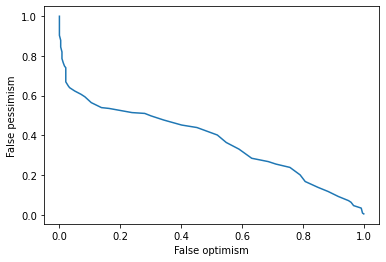

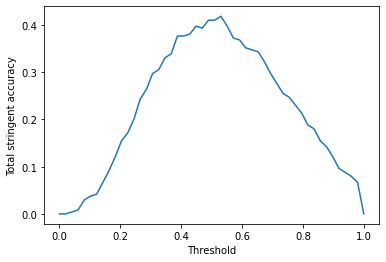

In [28]:
plot_false_optimism_pessimism(test_preds, y_test_no_goalies)

Since the accuracy is greatest at about threshold $0.5$, we decided not to particularly care about picking a threshold.

Altogether, these scores do not look so great, so let's take a look instead at how well each model performs individually.

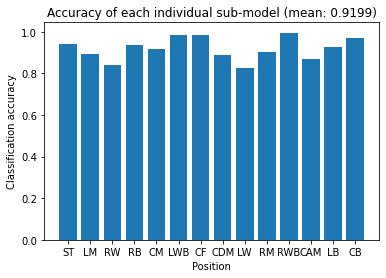

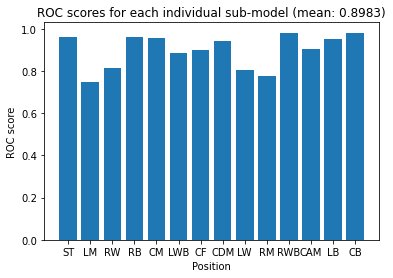

In [29]:
def get_score(model, X_test, y_test, position):
    predictions = model.predict_proba(X_test)[:,1]
    y_true = list(map(lambda k: (position in k)*1, y_test))
    return [roc_auc_score(y_true, predictions), accuracy_score(y_true, predictions > 0.5)]

def plot_scores(models):
    independent_model_scores = {p: get_score(m, q2_scaler.transform(X_test_no_goalies), y_test_no_goalies, p) for (p, m) in models.items()}
    accuracy_scores = {p: q[1] for (p, q) in independent_model_scores.items()}
    roc_scores = {p: q[0] for (p, q) in independent_model_scores.items()}
    plt.bar(accuracy_scores.keys(), accuracy_scores.values())
    plt.xlabel('Position')
    plt.ylabel('Classification accuracy')
    plt.title(f'Accuracy of each individual sub-model (mean: {np.mean(list(accuracy_scores.values())):.4g})')
    plt.show()
    plt.bar(roc_scores.keys(), roc_scores.values())
    plt.xlabel('Position')
    plt.ylabel('ROC score')
    plt.title(f'ROC scores for each individual sub-model (mean: {np.mean(list(roc_scores.values())):.4g})')
    plt.show()
    
plot_scores(models_RF)

They perform quite well.

As an example, let us examine the second player in the test set, who also happens to be the second player in the dataset.  (The first player, both in the dataset and in the test set, is a goalie.)  To a manager, he looks like this:

In [30]:
q2_players_19.iloc[1]

sofifa_id                                                192985
player_url    https://sofifa.com/player/192985/kevin-de-bruy...
short_name                                         K. De Bruyne
long_name                                       Kevin De Bruyne
age                                                          27
                                    ...                        
wr1_Low                                                       0
wr1_Medium                                                    0
wr2_High                                                      1
wr2_Low                                                       0
wr2_Medium                                                    0
Name: 4, Length: 111, dtype: object

To our model, he looks like this:

In [31]:
q2_data.drop(columns=['club', 'player_positions']).iloc[1]

age            27.0
height_cm     181.0
weight_kg      70.0
overall        91.0
potential      92.0
              ...  
wr1_Low         0.0
wr1_Medium      0.0
wr2_High        1.0
wr2_Low         0.0
wr2_Medium      0.0
Name: 4, Length: 93, dtype: float64

And we get the following predictions:

In [32]:
predictions_de_bruyne = predict_separate_models(models_RF, q2_scaler.transform([q2_data.drop(columns=['club', 'player_positions']).iloc[1]]))
predictions_de_bruyne

,ST,LM,RW,RB,CM,LWB,CF,CDM,LW,RM,RWB,CAM,LB,CB
0,0.22,0.33,0.32,0.03,0.49,0.07,0.37,0.26,0.34,0.32,0.1,0.54,0.09,0.13


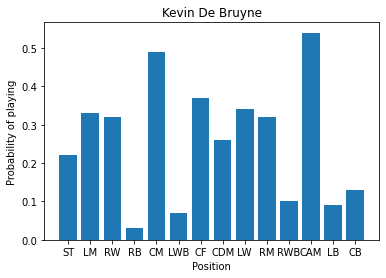

In [33]:
plt.bar(predictions_de_bruyne.columns, predictions_de_bruyne.values[0])
plt.xlabel('Position')
plt.ylabel('Probability of playing')
plt.title('Kevin De Bruyne')
plt.show()

In fact, De Bruyne plays:

In [34]:
q2_players_19.iloc[1]['player_positions']

'CAM, CM'

He's a midfielder, and indeed CAM and CM are given very high probabilities.  What's more, we can use this model to get further insights: there are many other positions that are given high probabilities, including midfield and center as well as wing, consistent with De Bruyne's reputation (according to https://en.wikipedia.org/wiki/Kevin_De_Bruyne#Style_of_play) as an extremely versatile player who often takes on a more general midfield role or acts as winger or second striker.

We can predict not only which positions players do play, but which positions they could.

This would on its own be a satisfactory visualization.  It gives a good impression of the competencies of a player.  However, for people who don't immediately know the difference between an `RWB` and a `CDM` (i.e. many people), a visualization aid is nice.  To create this, we use `mplsoccer`, a library designed for drawing soccer pitches.

In [36]:
player_positions_on_pitch = {
    "CB": (30, 40),
    "RW": (90, 70),
    "RWB": (40, 70),
    "LB": (25, 10),
    "LWB": (40, 10),
    "CF": (105, 40),
    "RM": (60, 70),
    "CAM": (75, 40),
    "CM": (60, 40),
    "ST": (90, 40),
    "CDM": (45, 40),
    "LW": (90, 10),
    "RB": (25, 70),
    "LM": (60, 10)
}


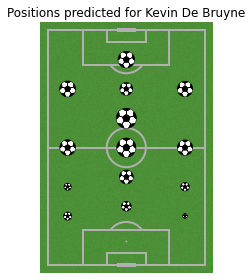

In [37]:
def show_scatter(player, name):
    pitch = Pitch(orientation='vertical', pitch_color='grass')
    fig, ax = pitch.draw()
    x_coord = []
    y_coord = []
    size = []
    size_constant = 800 # The size of a position which is 100% predicted for a player.
    for c in player.columns:
        x_coord.append(player_positions_on_pitch[c][1])
        y_coord.append(player_positions_on_pitch[c][0])
        size.append(size_constant * player[c])
    Pitch().scatter(x_coord, y_coord, s=size, marker='football', label='Player positions', ax=ax)
    ax.set_title(f'Positions predicted for {name}')

show_scatter(predictions_de_bruyne, 'Kevin De Bruyne')

Contrast this with the second non-goalie player in our test set, the third in our dataset, the more defensive (https://en.wikipedia.org/wiki/Sergio_Ramos#Style_of_play) Sergio Ramos, who actually plays:

In [38]:
q2_players_19.iloc[2]['player_positions']

'CB'

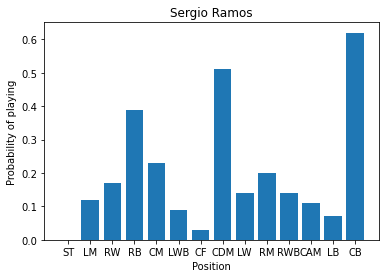

In [39]:
predictions_ramos = predict_separate_models(models_RF, q2_scaler.transform([q2_data.drop(columns=['club', 'player_positions']).iloc[2]]))
plt.bar(predictions_ramos.columns, predictions_ramos.values[0])
plt.xlabel('Position')
plt.ylabel('Probability of playing')
plt.title('Sergio Ramos')
plt.show()

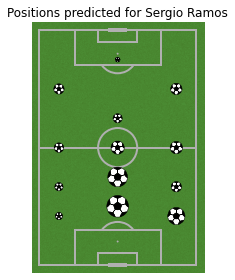

In [40]:
show_scatter(predictions_ramos, 'Sergio Ramos')

<a id="Q3"></a>

## <div class='exercise'> <b> Part C - Club with the Best Staff  </b></div>

In this section, we will:

* Study player data from Division 1 European League* players from the last 5 Years
* Analyze changes in player stats and value
* Rank the clubs according to best increase in statistics of a player
* Graphically represent the scores for the test set.

First, we organize the clubs by their respective leagues for the test set later on,

In [41]:
Premier_League_20 = ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton & Hove Albion','Burnley', 'Chelsea','Crystal Palace','Everton','Leicester City','Liverpool','Manchester City','Manchester United','Newcastle United','Norwich City','Sheffield United','Southampton','Tottenham Hotspur','Watford','West Ham United','Wolverhampton Wanderers']
Premier_League_19 = ['Arsenal','Aston Villa','Bournemouth','Brighton & Hove Albion','Burnley','Chelsea','Crystal Palace','Everton','Leicester City','Liverpool','Manchester City','Manchester United','Newcastle United','Norwich City','Sheffield United','Southampton','Tottenham Hotspur','Watford','West Ham United','Wolverhampton Wanderers']
Premier_League_18 = ['Arsenal','Bournemouth','Brighton & Hove Albion','Burnley','Cardiff City','Chelsea','Crystal Palace','Everton','Fulham','Huddersfield Town','Leicester City','Liverpool','Manchester City','Manchester United','Newcastle United','Southampton','Tottenham Hotspur','Watford','West Ham United','Wolverhampton Wanderers']
Premier_League_17 = ['Arsenal','Bournemouth','Brighton & Hove Albion','Burnley','Chelsea','Crystal Palace','Everton','Huddersfield Town','Leicester City','Liverpool','Manchester City','Manchester United','Newcastle United','Southampton','Stoke City','Swansea City','Tottenham Hotspur','Watford','West Bromwich Albion','West Ham United']
Premier_League_16 = ['Arsenal','Bournemouth','Burnley','Chelsea','Crystal Palace','Everton','Hull City','Leicester City','Liverpool','Manchester City','Manchester United','Middlesbrough','Southampton','Stoke City','Sunderland','Swansea City','Tottenham Hotspur','Watford','West Bromwich Albion','West Ham United']

Premier_League = set(Premier_League_20) & set(Premier_League_19) & set(Premier_League_18) & set(Premier_League_19) & set(Premier_League_20)

Bundesliga_German_20 = ['Arminia Bielefeld','FC Augsburg','Bayer Leverkusen','Bayern Munich','Borussia Dortmund','Borussia Mönchengladbach','Eintracht Frankfurt','SC Freiburg','Hertha BSC','1899 Hoffenheim','1. FC Köln','RB Leipzig','Mainz 05','Schalke 04','VfB Stuttgart','Union Berlin','Werder Bremen','VfL Wolfsburg']
Bundesliga_German_19 = ['FC Augsburg','Hertha BSC','Union Berlin','Werder Bremen','Borussia Dortmund','Fortuna Düsseldorf','Eintracht Frankfurt','SC Freiburg','1899 Hoffenheim','1. FC Köln','RB Leipzig','Bayer Leverkusen','Mainz 05','Borussia Mönchengladbach','Bayern Munich','SC Paderborn','Schalke 04','VfL Wolfsburg']
Bundesliga_German_18 = ['FC Augsburg','Hertha BSC','Werder Bremen','Borussia Dortmund','Fortuna Düsseldorf','Eintracht Frankfurt','SC Freiburg','Hannover 96','1899 Hoffenheim','RB Leipzig','Bayer Leverkusen','Mainz 05','Borussia Mönchengladbach','Bayern Munich','1. FC Nürnberg','Schalke 04','VfB Stuttgart','VfL Wolfsburg']
Bundesliga_German_17 = ['FC Augsburg', 'Hertha BSC','Werder Bremen','Borussia Dortmund','Eintracht Frankfurt','SC Freiburg','Hamburger SV','Hannover 96','1899 Hoffenheim','1. FC Köln','RB Leipzig','Bayer Leverkusen','Mainz 05','Borussia Mönchengladbach','Bayern Munich','Schalke 04','VfB Stuttgart','VfL Wolfsburg']
Bundesliga_German_16 = ['FC Augsburg','Bayer Leverkusen','Bayern Munich','Borussia Dortmund','Borussia Mönchengladbach','Darmstadt 98','Eintracht Frankfurt','SC Freiburg','Hamburger SV','Hertha BSC','1899 Hoffenheim','FC Ingolstadt','1. FC Köln','RB Leipzig','Mainz 05','Schalke 04','Werder Bremen','VfL Wolfsburg']

Bundesliga_German = set(Bundesliga_German_20) & set(Bundesliga_German_16) & set(Bundesliga_German_17) & set(Bundesliga_German_18) & set(Bundesliga_German_19)

Ligue_1_20 = ['Angers','Bordeaux','Brest','Dijon','Lens','Lille','Lorient','Lyon','Marseille','Metz','Monaco','Montpellier','Nantes','Nice','Nîmes','PSG','Reims','Rennes','Saint-Étienne','Strasbourg']
Ligue_1_19 = ['Amiens','Angers','Bordeaux','Brest','Dijon','Lille','Lyon','Marseille','Metz','Monaco','Montpellier','Nantes','Nice','Nîmes','PSG','Reims','Rennes','Saint-Étienne','Strasbourg','Toulouse']
Ligue_1_18 = ['Amiens','Angers','Bordeaux','Caen','Dijon','Guingamp','Lille','Lyon','Marseille','Monaco','Montpellier','Nantes','Nice','Nîmes','Paris Saint-Germain','Reims','Rennes','Saint-Étienne','Strasbourg','Toulouse']
Ligue_1_17 = ['Amiens','Angers','Bordeaux','Caen','Dijon','Guingamp','Lille','Lyon','Marseille','Metz','Monaco','Montpellier','Nantes','Nice','Paris Saint-Germain','Rennes','Saint-Étienne','Strasbourg','Toulouse','Troyes']
Ligue_1_16 = ['Angers','Bastia','Bordeaux','Caen','Dijon','Guingamp','Lille','Lorient','Lyon','Marseilles','Metz','Monaco','Montpellier','Nancy','Nantes','Nice','PSG','Reindeer','Saint Etienne','Toulouse']

Ligue_1 = set(Ligue_1_20) & set(Ligue_1_16) & set(Ligue_1_17) & set(Ligue_1_18) & set(Ligue_1_19)

La_Liga_Spain_20 = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona','Cádiz','Celta Vigo','Eibar','Elche','Getafe','Granada','Huesca','Levante','Osasuna','Real Betis','Real Madrid','Real Sociedad','Sevilla','Valencia','Valladolid','Villarreal']      
La_Liga_Spain_19 = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona','Celta Vigo','Eibar','Espanyol','Getafe','Granada','Leganés','Levante','Mallorca','Osasuna','Real Betis','Real Madrid','Real Sociedad','Sevilla','Valencia','Valladolid','Villarreal']
La_Liga_Spain_18 = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona','Celta Vigo','Eibar','Espanyol','Getafe','Girona','Huesca','Leganés','Levante','Rayo Vallecano','Real Betis','Real Madrid','Real Sociedad','Sevilla','Valencia','Valladolid','Villarreal']
La_Liga_Spain_17 = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona','Celta Vigo','Deportivo La Coruña','Eibar','Espanyol','Getafe','Girona','Las Palmas','Leganés','Levante','Málaga','Real Betis','Real Madrid','Real Sociedad','Sevilla','Valencia','Villarreal']
La_Liga_Spain_16 = ['Alavés','Athletic Bilbao','Atlético Madrid','Barcelona','Celta Vigo','Deportivo La Coruña','Eibar','Espanyol','Granada','Las Palmas','Leganés','Málaga','Osasuna','Real Betis','Real Madrid','Real Sociedad','Sevilla','Sporting Gijón','Valencia','Villarreal']

La_Liga_Spain = set(La_Liga_Spain_20) & set(La_Liga_Spain_16) & set(La_Liga_Spain_17) & set(La_Liga_Spain_18) & set(La_Liga_Spain_19)

Serie_A_Italian_20 = ['Atalanta','Benevento','Bologna','Cagliari','Crotone','Fiorentina','Genoa','Hellas Verona','Internazionale','Juventus','Lazio','Milan','Napoli','Parma','Roma','Sampdoria','Sassuolo','Spezia','Torino','Udinese']
Serie_A_Italian_19 = ['Atalanta','Bologna','Brescia','Cagliari','Fiorentina','Genoa','Hellas Verona','Internazionale','Juventus','Lazio','Lecce','Milan','Napoli','Parma','Roma','Sampdoria','Sassuolo','SPAL','Torino','Udinese']
Serie_A_Italian_18 = ['Atalanta','Bologna','Cagliari','Chievo','Empoli','Fiorentina','Frosinone','Genoa','Internazionale','Juventus','Lazio','Milan','Napoli','Parma','Roma','Sampdoria','Sassuolo','SPAL','Torino','Udinese']
Serie_A_Italian_17 = ['Atalanta','Benevento','Bologna','Cagliari','Chievo','Crotone','Fiorentina','Genoa','Hellas Verona','Internazionale','Juventus','Lazio','Milan','Napoli','Roma','Sampdoria','Sassuolo','SPAL','Torino','Udinese']
Serie_A_Italian_16 = ['Atalanta','Bologna','Cagliari','Chievo','Crotone','Empoli','Fiorentina','Genoa','Internazionale','Juventus','Lazio','Milan','Napoli','Palermo','Pescara','Roma','Sampdoria','Sassuolo','Torino','Udinese']

Serie_A_Italian = set(Serie_A_Italian_20) & set(Serie_A_Italian_16) & set(Serie_A_Italian_17) & set(Serie_A_Italian_18) & set(Serie_A_Italian_19)


In [42]:
q_3_players_16 = pd.read_csv('players_16.csv')
q_3_players_17 = pd.read_csv('players_17.csv')
q_3_players_18 = pd.read_csv('players_18.csv')
q_3_players_19 = pd.read_csv('players_19.csv')
q_3_players_20 = pd.read_csv('players_20.csv')
league = pd.read_csv('teams_and_leagues.csv')

q_3_players = list([q_3_players_16, q_3_players_17, q_3_players_18, q_3_players_19, q_3_players_20])

In [43]:
q_3_players_20_position_ovr = q_3_players_20[['sofifa_id', 'player_positions', 'overall']].copy()
q_3_players_20_position_ovr.columns = ['sofifa_id', 'player_positions_20', 'overall_20']
q_3_players_19 = q_3_players_19.merge(q_3_players_20_position_ovr, how='outer', on='sofifa_id')

All teams:

In [44]:
q_3_scaler = StandardScaler()

players_new = []
unnormalized_players = []

for group in q_3_players:

    group = group[group.body_type.isin(('Lean', 'Normal', 'Stocky'))]
    body_type_one_hot = pd.get_dummies(group.body_type, prefix='body_type')
    group = group.merge(body_type_one_hot, left_index=True, right_index=True).drop(columns='body_type')

    group['preferred_foot'] = (group['preferred_foot'] == 'Right')*1

    for i in numeric_skills:
        group[i] = group[i].apply(lambda x: int(re.search(r'\d+', x).group()) if type(x) == str else np.NaN)

    group[goalie_nongoalie_skills] = group[goalie_nongoalie_skills].fillna(0) # A non-goalie could technically go in goal, but would be awful at it.

    group[['work_rate_1', 'work_rate_2']] = group.work_rate.str.split('/', n=1, expand=True)
    wr1_one_hot = pd.get_dummies(group.work_rate_1, prefix='wr1')
    wr2_one_hot = pd.get_dummies(group.work_rate_2, prefix='wr2')
    group = group.merge(wr1_one_hot, left_index=True, right_index=True).merge(wr2_one_hot, left_index=True, right_index=True).drop(columns=['work_rate', 'work_rate_1', 'work_rate_2'])

    group = group.drop(columns=['body_type_Normal','body_type_Stocky','height_cm','weight_kg','preferred_foot','weak_foot','body_type_Lean','age','international_reputation','value_eur','sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'nationality', 'real_face', 'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_jersey_number', 'wage_eur', 'player_traits', 'nation_position', 'release_clause_eur','player_positions','team_position'])
    df = group['club']
    group = group.drop('club', axis=1)
    group = group.fillna(0)
    unnormalized_players.append(group)
    group = (group-group.mean())/group.std()
    group['club'] = df
    group = group.fillna(0)
    players_new.append(group)
    

At this point we have a dataframe full of players, and we would like a dataframe full of clubs.  There are multiple ways to go about doing this, and the obvious one is to consider each player individually, score him, and then take some kind of average to get a score for the club.  However, we wanted a broader model than that, and a model that would allow for a rigorization of such idiomatic statements as "Aston Villa can't pass this year" or "Manchester United's got much better at defense".  Therefore, we average skills over all players before we do any modelling, to consider the "standard player from club X".  This does indeed lose information, and is in general not a great way to represent a football team, but it is a good way to determine what a club focuses on and how that changes year by year, which is the point of this exercise.

In [45]:
teams = []

for group in players_new:
    teams.append(group.groupby('club').mean())

Test set:

In [46]:
teams_Premier = []
teams_Bundesliga = []
teams_Ligue = []
teams_La_Liga = []
teams_Serie_A = []

for i in range (len(players_new)):
    new_premier = teams[i].loc[teams[i].index.isin(Premier_League)]
    new_Bundesliga = teams[i].loc[teams[i].index.isin(Bundesliga_German)]
    new_Ligue = teams[i].loc[teams[i].index.isin(Ligue_1)]
    new_La_Liga = teams[i].loc[teams[i].index.isin(La_Liga_Spain)]
    new_Serie_A = teams[i].loc[teams[i].index.isin(Serie_A_Italian)]
    
    teams_Premier.append(new_premier)
    teams_Bundesliga.append(new_Bundesliga)
    teams_Ligue.append(new_Ligue)
    teams_La_Liga.append(new_La_Liga)
    teams_Serie_A.append(new_Serie_A)


Merging each year's teams dataframes into one to make things simpler:

In [47]:
test_sets = []

for i in range(5):
    frames = [teams_Premier[i], teams_Bundesliga[i], teams_Ligue[i], teams_La_Liga[i], teams_Serie_A[i]]
    result = pd.concat(frames)
    test_sets.append(result)

These are the final test sets that need to be used to test the prediction for 2021. test_sets contains 5 dataframes
years 2016 through 2020, of the clubs that played in the European League.
Below, we will classify these clubs according to their overall values

In [48]:
sorted_test_sets = []

for i in range(len(test_sets)):    
    sorted_test_sets.append(test_sets[i].sort_values('overall', ascending=False))

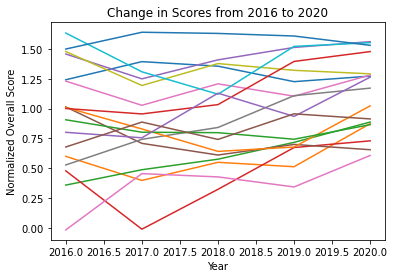

In [49]:
# The plot looks ugly but I just wanted to see how some of the scores changed over the years

x = np.linspace(2016, 2020, 5)

for i in range(len(teams_Premier[0])):
    y = []
    for j in range(len(teams_Premier)):
        y.append(teams_Premier[j]['overall'][i])
    plt.plot(x,y)
    plt.title('Change in Scores from 2016 to 2020')
    plt.xlabel('Year')
    plt.ylabel('Normalized Overall Score')

We now have to find a way of scoring the clubs out of 100, given their average scores.  The most obvious question is whether or not those scores have gone up or down, and by how much.  Linear models are fantastic at finding out how much a score goes up or down, so we train one on each score.  We would like better clubs to have more scores that go up, so we take the average slope of each linear regression and let that be our score.

In [50]:
skills = test_sets[0].columns

overall = []

for club in range(len(test_sets[0])):
    new = []
    for skill in range(len(skills)):
        l = []
        for year in range(len(test_sets)):
            l.append(test_sets[year][skills[skill]][club])
        new.append(l)
    overall.append(new)

In [51]:
overall[1]

x = [[2016], [2017], [2018], [2019], [2020]]

club_skills = []
scores = []
total_mse = []
club_2021 = []

for club in range(len(overall)):
    
    coefficients = []
    each_skill = []
    mse_skills = []
    skills_2021 = []
    
    for skill in range(len(overall[0])):
        
        y = overall[club][skill]

        lreg = LinearRegression()
        lreg.fit(x,y)

        y_pred = lreg.predict(x)
        y_2021 = lreg.predict([[2021]])
        
        skills_2021.append(y_2021)
        
        MSE = ((y - y_pred)**2).mean()
        mse_skills.append(MSE)

        coeff = lreg.coef_
        coefficients.append(coeff)
        
        each_skill.append(y_pred)
        
    club_skills.append(each_skill)
    scores.append(np.mean(coefficients))
    total_mse.append(np.mean(mse_skills))
    club_2021.append(skills_2021)

Text(0.5, 0, 'Score')

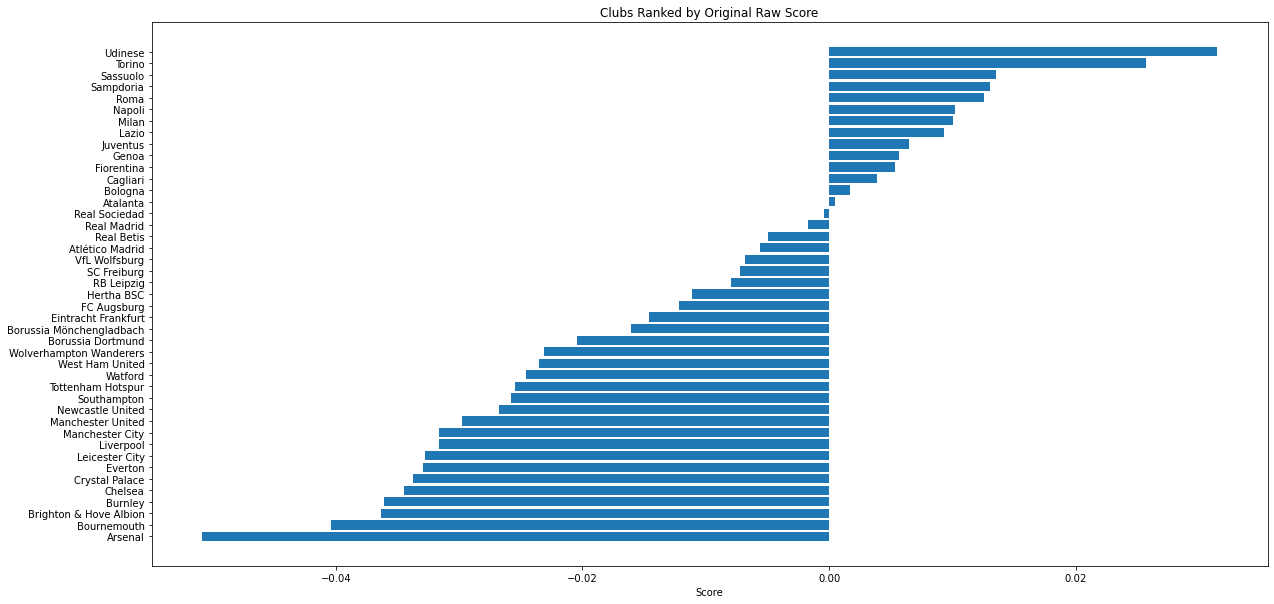

In [52]:
sorted_scores = np.sort(scores)

plt.rcParams["figure.figsize"] = 20,10

plt.barh(test_sets[0].index,sorted_scores)
plt.title('Clubs Ranked by Original Raw Score')
plt.xlabel('Score')

We were curious as to what all the skills for the highest and lowest ranked clubs were so we plotted all the skills for Udinese and Arsenal.

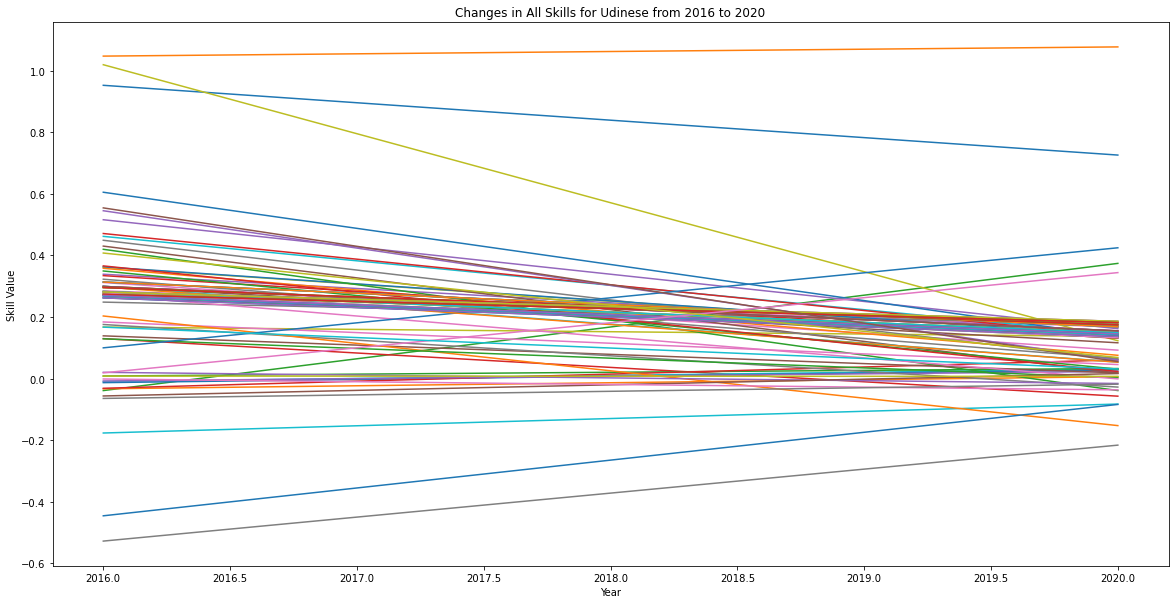

In [53]:
x = np.linspace(2016,2020,5)
for i in range(len(club_skills[-1])):
    plt.plot(x,club_skills[-1][i])
    plt.title('Changes in All Skills for Udinese from 2016 to 2020')
    plt.xlabel('Year')
    plt.ylabel('Skill Value')

While most of the lines seem to be flat or negatively sloped, there are a handful of clearly positive slopes.

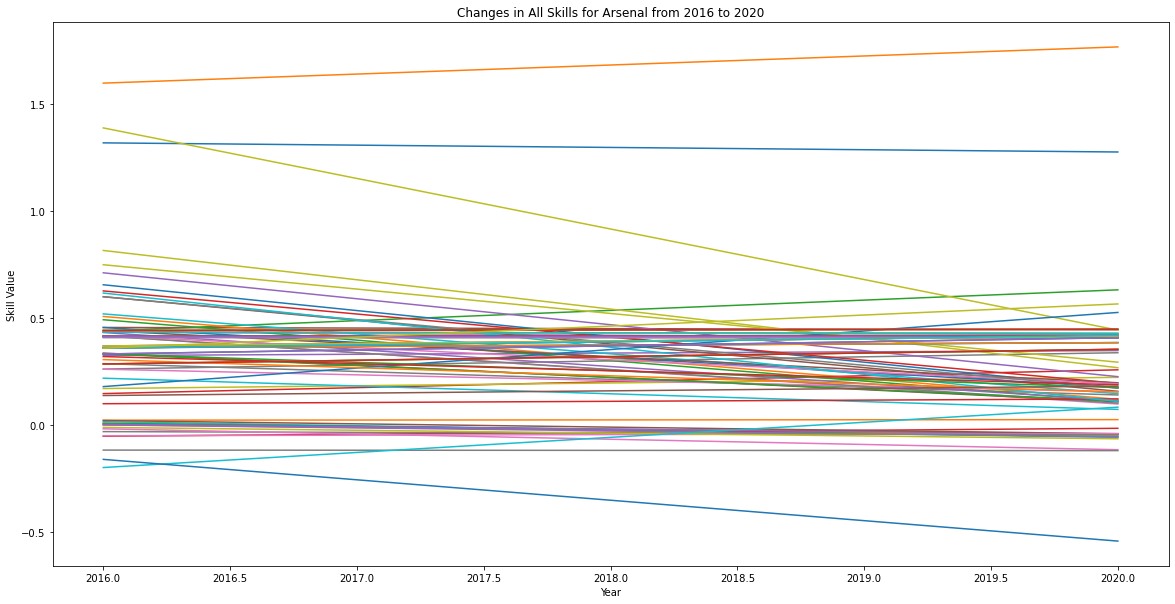

In [54]:
for i in range(len(club_skills[0])):
    plt.plot(x,club_skills[0][i])
    plt.title('Changes in All Skills for Arsenal from 2016 to 2020')
    plt.xlabel('Year')
    plt.ylabel('Skill Value')

There are barely any lines with positive slope, and the few there are, are pretty much flat.

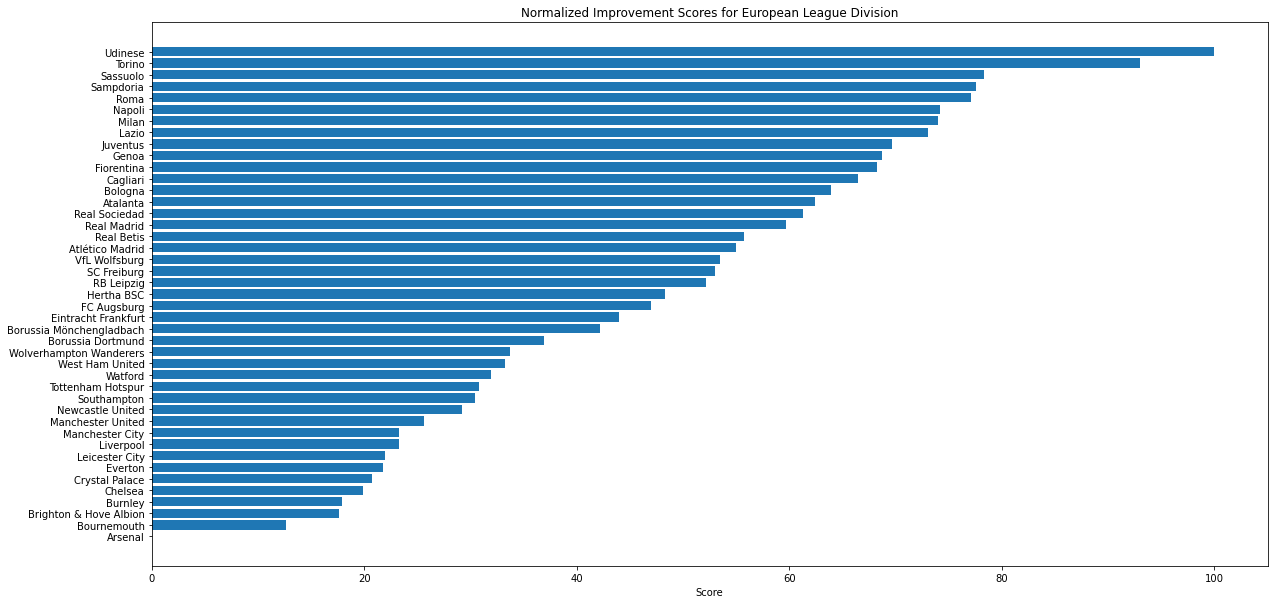

In [55]:
normalized_scores = ((scores-np.min(scores))/(np.max(scores)-np.min(scores)))*100
sorted_normalized_scores = np.sort(normalized_scores )

plt.rcParams["figure.figsize"] = 20,10

plt.barh(test_sets[0].index,sorted_normalized_scores)
plt.title('Normalized Improvement Scores for European League Division')
plt.xlabel('Score')
plt.show()

Finally, we examine the mean squared errors for each linear model which, while not fantastic, are also not bad given that our goal was not to accurately predict exactly how well the clubs would do but to get a ranking for which did best and by about how much.

In [56]:
mean_mse = np.mean(total_mse)

mse_score = total_mse / mean_mse

normalized_mse = ((mse_score-np.min(mse_score))/(np.max(mse_score)-np.min(mse_score)))*100
normalized_mse

array([ 31.72384577,  22.3535116 ,  16.36708991,  47.65780968,
        38.59566919,   9.822729  ,  24.91816489,  35.25736446,
        35.9419447 ,  43.17878592, 100.        ,  10.76903346,
         7.01350491,  44.31655391,  24.50724864,  24.30778642,
        27.74972495,  31.72938705,  21.48031191,  14.68918632,
         4.16637229,   4.75853582,   9.4360518 ,   0.        ,
        11.81278669,  17.05269513,  36.74394291,  61.0953034 ,
        19.27332589,  11.06492736,  11.61579013,  34.1360643 ,
        33.12497236,  20.20106575,  88.26243265,  37.91939355,
        77.52197015,  58.59039398,  49.87721918,  15.51265498,
        18.13450492,  26.11061347,  20.37859001])

In part C, we had predicted the new skills stats for the 2020-2021 season for each club using the Linear Regression model we had built. Because we had normalized the data for our model, the main challenge in this section was to ‘unnormalize’ our numbers.

Because taking the mean only gave us the mean of the averages for each year, we took the mean again to get the mean of all five years. We did the same thing to get the overall standard deviation. We then multiplied the newly predicted skill stat values by the standard deviation and added back the mean to get more easily readable unnormalized values. 

We displayed the new mean skill stats for the clubs in 2021 in a Pandas DataFrame

In [57]:
mean = []
std = []

for i in range(len(unnormalized_players)):
    mean.append(unnormalized_players[i].mean())
    std.append(unnormalized_players[i].std())


mean_avg = []
std_avg = []

for i in range(len(mean[0])):
    x_mean_new = []
    x_std_new = []
    
    for j in range(len(mean)):
        x_mean_new.append(mean[j][i])
        x_std_new.append(std[j][i])
    mean_avg.append(np.mean(x_mean_new))
    std_avg.append(np.mean(x_std_new))

In [58]:
players_21 = []

for i in range(len(club_2021)):
    m = []
    for j in range(len(club_2021[0])):
        x = (club_2021[i][j] * std_avg[j]) + mean_avg[j]
        m.append(x[0])
    players_21.append(m)

In [59]:
club_mean_2021_df = pd.DataFrame(players_21, columns=skills, index = test_sets[0].index)

In [60]:
club_mean_2021_df

,overall,potential,skill_moves,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,lcb,cb,rcb,rb,wr1_High,wr1_Low,wr1_Medium,wr2_High,wr2_Low,wr2_Medium
club,,,,,,,,,,,,,,,,,,,,,
Arsenal,75.012563,82.240450,2.831273,67.282425,53.961401,59.801595,63.956589,53.550456,63.054865,5.705891,...,57.331066,57.331066,57.331066,59.358024,0.337489,0.020453,0.639317,0.385099,0.134018,0.474547
Bournemouth,71.649406,77.959770,2.510899,59.378984,51.177993,55.892139,59.379244,49.338032,57.599187,8.616500,...,52.670020,52.670020,52.670020,54.135481,0.230526,0.026342,0.738982,0.176894,0.029007,0.788370
Brighton & Hove Albion,73.088467,77.674440,2.808629,58.886073,56.074789,58.566634,62.640940,49.449664,61.561879,6.421126,...,54.081915,54.081915,54.081915,54.954479,0.318557,0.042598,0.637341,0.367616,0.032304,0.592514
Burnley,71.713111,75.181012,2.326682,53.712461,48.042049,53.485397,56.033380,49.714611,56.213987,12.156402,...,52.455576,52.455576,52.455576,52.456539,0.220671,0.001789,0.776720,0.264362,0.004287,0.722208
Chelsea,77.207843,82.378488,2.729729,60.713652,53.430951,61.863317,64.610901,54.079113,59.442118,9.752649,...,56.852574,56.852574,56.852574,58.422501,0.286314,0.047940,0.661640,0.209208,0.062215,0.724349
Crystal Palace,69.783760,75.397719,2.513486,55.155394,48.662478,54.898846,57.748010,52.848533,61.157649,5.780962,...,55.870742,55.870742,55.870742,54.723846,0.287150,0.071227,0.640772,0.239881,0.068404,0.692637
Everton,74.715731,79.624472,2.702581,62.577207,57.306664,59.333010,64.390472,49.948408,62.865673,6.643704,...,55.397733,55.397733,55.397733,56.238780,0.447052,0.081456,0.468391,0.253816,0.036873,0.702972
Leicester City,75.774743,79.725096,2.711042,59.633755,52.083493,59.498082,63.110757,56.280022,62.068956,7.887876,...,58.602271,58.602271,58.602271,58.701279,0.297726,0.071969,0.628782,0.521486,0.081076,0.384843
Liverpool,74.961216,82.329604,2.838796,63.092382,52.920829,59.251690,63.180676,52.448348,58.975560,9.766479,...,55.639977,55.639977,55.639977,57.432734,0.519083,-0.015566,0.490757,0.284179,-0.004525,0.713446


<a id="Q4"></a>

## <div class='exercise'> <b> Part D - Predicting Skill Stats for 2021  </b></div>

In this section, we will:

* Go through data for player skill changes, predict the new skill stats for the test set players in the 2020-21 season, using the data from Part C

In [61]:
q4_players_16 = pd.read_csv('players_16.csv')
q4_players_17 = pd.read_csv('players_17.csv')
q4_players_18 = pd.read_csv('players_18.csv')
q4_players_19 = pd.read_csv('players_19.csv')
q4_players_20 = pd.read_csv('players_20.csv')
q4_league = pd.read_csv('teams_and_leagues.csv')

q4_players = list([q4_players_16, q4_players_17, q4_players_18, q4_players_19, q4_players_20])

Just as we did in Part C, we refine our dataset containing players from 2016 to 2020 and take out irrelevant attributes

In [62]:
q4_players_new = []

for group in q4_players:

    numeric_skills = ('attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb')

    for i in numeric_skills:
        group[i] = group[i].apply(lambda x: int(re.search(r'\d+', x).group()) if type(x) == str else np.NaN)

    goalie_nongoalie_skills = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
    # A non-goalie could technically go in goal, but would be awful at it.
    group[goalie_nongoalie_skills] = group[goalie_nongoalie_skills].fillna(0) 

    group[['work_rate_1', 'work_rate_2']] = group.work_rate.str.split('/', n=1, expand=True)
    wr1_one_hot = pd.get_dummies(group.work_rate_1, prefix='wr1')
    wr2_one_hot = pd.get_dummies(group.work_rate_2, prefix='wr2')
    group = group.merge(wr1_one_hot, left_index=True, right_index=True).merge(wr2_one_hot, left_index=True, right_index=True).drop(columns=['work_rate', 'work_rate_1', 'work_rate_2'])

    group = group.drop(columns=['body_type','height_cm','weight_kg','preferred_foot','weak_foot','age','international_reputation','value_eur', 'player_url', 'long_name', 'dob', 'nationality', 'real_face', 'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_jersey_number', 'wage_eur', 'player_traits', 'nation_position', 'release_clause_eur','player_positions','team_position', 'wr1_High', 'wr1_Low', 'wr1_Medium', 'wr2_High', 'wr2_Low', 'wr2_Medium'])
    group['id'] = group['sofifa_id']
    group = group.set_index('sofifa_id')
    q4_players_new.append(group)

Here, I calculate the mean skill stats for all clubs in the dataset for that year for all years

In [63]:
q4_club_mean = []

for year in range(len(q4_players_new)):
    skills_mean = q4_players_new[year].drop(columns='id').groupby(['club']).mean()
    q4_club_mean.append(skills_mean)

This dict contains all of the clubs, which are the keys, and the id of all the members of a particular club, which is that corresponding club/key's values. This way, it'll be easy to create a roster later on of people who were in the same club the year prior.

In [64]:
list_of_roster_dict = []

for year in range(len(q4_players_new)):
    idlist = q4_players_new[year].groupby(['club']).id.unique()
    club_roster_dict = idlist.to_dict()
    list_of_roster_dict.append(club_roster_dict)

This list is to keep track of all the clubs that are in the dataset for a given year. This will be useful for when we want to iterate over every club to create the roster we'll use in the next year.

In [65]:
list_of_clubs = []

for year in range(len(q4_players_new)):
    club_list_for_that_year = list(list_of_roster_dict[year].keys())
    list_of_clubs.append(club_list_for_that_year)

Similar idea as above, but for when we want to easily iterate over every player who existed in the dataset for a given year.

In [66]:
list_of_player_ids = []

for year in range(len(q4_players_new)):
    player_id_list_for_that_year = q4_players_new[year].id.values
    list_of_player_ids.append(player_id_list_for_that_year)

We calculate the mean skill stats for all rosters, much like we did for q4_club_mean, except we only start considering the idea of a roster after the first year. We are essentially 'freezing' the list of people who played in the same club one year and looking at their mean skill stats a year later. We do this to account for the fact that players may have switched clubs year to year.

In [67]:
roster_average = []

for year in range(len(q4_players_new) - 1):
    next_year_rosters = {}
    for club in list_of_clubs[year]:
        roster_list = list(list_of_roster_dict[year].get(club))
        roster = q4_players_new[year+1]['id'].isin(roster_list)
        roster_avg = q4_players_new[year+1][roster].drop(columns=['id']).mean()
        next_year_rosters[club] = roster_avg
    roster_average.append(next_year_rosters)

We then calculate the roster delta, which is defined to be the club mean of a given year minus the mean of the same group of people from that club the next year.

In [68]:
roster_deltas = []

for year in range(len(q4_players_new)-1):
    this_year_delta = {}
    for club in list_of_clubs[year]:
        delta = roster_average[year][club] - q4_club_mean[year].loc[club]
        this_year_delta[club] = delta
    roster_deltas.append(this_year_delta)


We calculate the club delta for 2020 to 2021 separately here, since not all of the clubs we're looking at in this dataset had their mean skill stats predicted in part C. We only considered clubs in the 5 test set leagues in part C, which gave us 42 clubs, whereas here, we are looking at more than 600 clubs every year.

We have the club mean skills for 2021 for a limited numebr of clubs, as predicted by the linreg in part C. We calculate the delta by subtracting the club mean skills in 2020 from the predicted club mean skills for 2021.

It would be better to use roster numbers for this rather than club numbers but since we don't know who's going to get traded, and because predicting roster values is the whole point of this section, we can't use those numbers in our calculation.

In [69]:
club_means_predicted_2021 = club_mean_2021_df[list(q4_club_mean[0].columns.values)]

club_delta_2020_2021 = club_means_predicted_2021.subtract(q4_club_mean[-1].loc[list(club_means_predicted_2021.index.values)])

Now just as we did for the clubs/rosters, we calculate the delta for each player.

In [70]:
player_deltas = []

for year in range(len(q4_players_new)-1):
    this_year_delta = {}
    for player_id in list_of_player_ids[year]:
        if player_id in list_of_player_ids[year+1]:
            delta = q4_players_new[year+1].drop(columns=['short_name','club','id']).loc[player_id] - q4_players_new[year].drop(columns=['short_name','club','id']).loc[player_id]
            this_year_delta[player_id] = delta
    player_deltas.append(this_year_delta)

I created this dictionary that mapped player_id to club so that I could easily retrieve a player's associated club later on.

In [71]:
# reverse dictionary list_of_roster_dict so that keys are player_id and values are the player's corresponding club
dict_of_player_id_with_clubs = []

for year in range(len(q4_players_new)):
    dict_for_that_year = {v: k for k, values in list_of_roster_dict[year].items() for v in values}
    dict_of_player_id_with_clubs.append(dict_for_that_year)

Here, we come up with an idea of an 'overachievement' or 'underachievement' factor, depending on how much a player improves relative to his team. We calculate the difference between the player delta and the average delta of the player's roster/club, so that difference = player_delta[year] - roster_delta[year] of that player's roster/club. This is to account for the fact that a good player will still improve by a fair amount in a bad club, and so we wanted a way to quantify how much the player went above and beyond his club's training regimen.

In [72]:
player_roster_diff = []

for year in range(len(q4_players_new)-1):
    diff_for_year = {}
    for player_id in list_of_player_ids[year]:
        if player_id in player_deltas[year]:
            associated_club = dict_of_player_id_with_clubs[year][player_id]
            diff = player_deltas[year][player_id] - roster_deltas[year][associated_club]
            diff_for_year[player_id] = diff.fillna(0)
    player_roster_diff.append(diff_for_year)

I created this set of ids which stores all the unique ids in the time period 2016-2020 in our dataset. This is so that I can easily iterate over every player_id without using lists that are tied to specific years.

In [73]:
set_of_ids = set()
for year in range(len(player_roster_diff)):
    for ids in player_roster_diff[year]:
        set_of_ids.add(ids)

The avg_factor stores the calculated mean of the 'overachievement'/'underachievement' factor for the players. Since we had only 4 points for every player, we felt justified in taking the mean rather than fit those points to a model. 

In [74]:
avg_factor = {}

for player_id in set_of_ids:
    mean = pd.Series(dtype='float64')
    for year in range(len(player_roster_diff)):
        years_count = 0
        if player_id in player_roster_diff[year]:
            years_count = years_count + 1
            mean = mean.add(player_roster_diff[year][player_id], fill_value=0)
    avg_factor[player_id] = mean/(years_count if years_count > 0 else 1) 

Now that we have club delta between 2020 and 2021 as well as the mean overachievement factor, we can add those to the static 2020 skill stats. Since the club-wide skill predictions for 2021 were available to a limited number of clubs, we added the club delta if we had the prediction and did nothing if there was no club delta available (this meant we were assuming that the club did not improve). While this wasn't ideal, it was the best we could do given what we had from Part C and there didn't tend to be dramatic club-wide improvements year to year anyway.

In [75]:
player_2021 = pd.DataFrame()    


for player_id in list(avg_factor.keys()):
    if player_id in (q4_players_new[4]['id'].values):
        player_2020_series = q4_players_new[4].drop(columns=['short_name','id']).loc[player_id]
        player_id_series = q4_players_new[4][['id']].loc[player_id]

        club = player_2020_series['club']
        player_2020_series = player_2020_series.drop(labels=['club'])
                
        if club in list(club_delta_2020_2021.index.values):
            player_pred = player_2020_series.add(avg_factor[player_id], fill_value=0).add(club_delta_2020_2021.loc[club], fill_value=0)
        else:
            player_pred = player_2020_series.add(avg_factor[player_id], fill_value=0)
       
        player_pred = player_pred.append(player_id_series)
        player_2021_frame = player_pred.to_frame().transpose()
        player_2021_frame.id = player_2021_frame.id.astype(int)
        player_2021 = player_2021.append(player_2021_frame, ignore_index=True)
player_2021 = player_2021.set_index('id')

In [76]:
player_2021

,overall,potential,skill_moves,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
id,,,,,,,,,,,,,,,,,,,,,
768,70.3574,72.7471,1.57691,20.0226,30.6725,46.7685,47.5242,72.4578,51.9098,0.225409,...,52.5385,60.942,60.942,60.942,52.5385,55.4935,66.3929,66.3929,66.3929,55.4935
1179,77.6299,79.0366,0.582182,-0.80531,-6.08216,-7.27436,-7.69608,-6.03229,-4.53252,73.6809,...,-4.47124,-5.30193,-5.30193,-5.30193,-4.47124,-4.25678,-4.83873,-4.83873,-4.83873,-4.25678
132740,73.0737,76.6858,0.574035,0.797193,-8.15158,-7.56515,-7.98659,-8.06659,-7.33942,80.0838,...,-5.78308,-7.07415,-7.07415,-7.07415,-5.78308,-5.49053,-6.56234,-6.56234,-6.56234,-5.49053
2147,64.0876,69.6932,0.403559,3.63527,-4.55697,-7.29299,-5.19203,-4.97808,-2.2704,62.0346,...,-3.34753,-4.38906,-4.38906,-4.38906,-3.34753,-3.00931,-3.63404,-3.63404,-3.63404,-3.00931
133249,59.307,64.3453,3.46226,38.8663,53.4178,65.2649,65.6182,57.9001,49.2502,-0.900318,...,52.3312,58.9306,58.9306,58.9306,52.3312,52.6799,56.6965,56.6965,56.6965,52.6799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125586,50.3752,54.5375,0.596207,-3.12101,-6.48535,-7.34946,-7.56913,-2.31834,-4.59814,57.116,...,-3.68674,-4.63761,-4.63761,-4.63761,-3.68674,-2.88821,-2.69022,-2.69022,-2.69022,-2.88821
125871,77.6869,78.0205,2.60901,70.5917,55.1548,65.3143,71.5142,68.6956,63.6666,4.65186,...,70.9122,67.9559,67.9559,67.9559,70.9122,69.9893,66.9893,66.9893,66.9893,69.9893
125995,62.7856,66.4994,2.99498,48.0509,75.3338,53.8473,60.8335,33.156,65.7494,-7.53028,...,46.295,45.1859,45.1859,45.1859,46.295,45.0897,46.599,46.599,46.599,45.0897


Here we clamped the values so that there weren't any negative skill stat values.

In [77]:
player_2021[player_2021 < 0] = 0
player_2021

,overall,potential,skill_moves,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
id,,,,,,,,,,,,,,,,,,,,,
768,70.3574,72.7471,1.57691,20.0226,30.6725,46.7685,47.5242,72.4578,51.9098,0.225409,...,52.5385,60.942,60.942,60.942,52.5385,55.4935,66.3929,66.3929,66.3929,55.4935
1179,77.6299,79.0366,0.582182,0,0,0,0,0,0,73.6809,...,0,0,0,0,0,0,0,0,0,0
132740,73.0737,76.6858,0.574035,0.797193,0,0,0,0,0,80.0838,...,0,0,0,0,0,0,0,0,0,0
2147,64.0876,69.6932,0.403559,3.63527,0,0,0,0,0,62.0346,...,0,0,0,0,0,0,0,0,0,0
133249,59.307,64.3453,3.46226,38.8663,53.4178,65.2649,65.6182,57.9001,49.2502,0,...,52.3312,58.9306,58.9306,58.9306,52.3312,52.6799,56.6965,56.6965,56.6965,52.6799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125586,50.3752,54.5375,0.596207,0,0,0,0,0,0,57.116,...,0,0,0,0,0,0,0,0,0,0
125871,77.6869,78.0205,2.60901,70.5917,55.1548,65.3143,71.5142,68.6956,63.6666,4.65186,...,70.9122,67.9559,67.9559,67.9559,70.9122,69.9893,66.9893,66.9893,66.9893,69.9893
125995,62.7856,66.4994,2.99498,48.0509,75.3338,53.8473,60.8335,33.156,65.7494,0,...,46.295,45.1859,45.1859,45.1859,46.295,45.0897,46.599,46.599,46.599,45.0897


In [78]:
players_20_sofifa = q4_players_20.set_index('sofifa_id')

Here we zero'ed out goalie skills for non goalie players and non-goalie skills for goalie players.

In [79]:
gk_skills = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning']
non_gk_skills = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

player_2021['player_positions'] = players_20_sofifa[['player_positions']]
player_2021_goalie = player_2021[player_2021['player_positions'].str.contains('GK')]
player_2021_not_goalie = player_2021[~ player_2021['player_positions'].str.contains('GK')]

player_2021_goalie[non_gk_skills] = 0
player_2021_not_goalie[gk_skills] = 0

player_2021 = pd.concat([player_2021_goalie, player_2021_not_goalie])

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/pandas/core/frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Lastly, we added back the name column as we had been dealing with just player_ids.

In [80]:
non_name_columns = list(player_2021.columns.values)
player_2021['name'] = players_20_sofifa[['long_name']]
player_2021 = player_2021[['name'] + non_name_columns]
player_2021

,name,overall,potential,skill_moves,pace,shooting,passing,dribbling,defending,physic,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,player_positions
id,,,,,,,,,,,,,,,,,,,,,
1179,Gianluigi Buffon,77.6299,79.0366,0.582182,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GK
132740,Jesper Hansen,73.0737,76.6858,0.574035,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GK
2147,Maarten Stekelenburg,64.0876,69.6932,0.403559,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GK
135043,Anders Lindegaard,65.5465,67.2933,0.910173,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GK
135451,Heurelho da Silva Gomes,72.3388,76.8764,0.645269,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124607,Selçuk İnan,60.9266,65.0492,2.64411,27.0317,60.4274,65.7205,56.1981,51.5722,48.9963,...,53.252,53.252,53.252,51.5919,48.9239,51.7464,51.7464,51.7464,48.9239,"CM, CDM"
124635,Mehmet Topal,70.6869,74.0205,3.60901,39.5917,57.1548,54.3143,61.5142,61.6956,61.6666,...,63.9559,63.9559,63.9559,60.9122,60.9893,59.9893,59.9893,59.9893,60.9893,"CDM, CB"
125871,Hasan Ali Kaldırım,77.6869,78.0205,2.60901,70.5917,55.1548,65.3143,71.5142,68.6956,63.6666,...,67.9559,67.9559,67.9559,70.9122,69.9893,66.9893,66.9893,66.9893,69.9893,LB
